####  In this post we will look at how we can use WITH statments, Correlated Subqueries, and VIEW's to answer some business questions using the Chinook database. 
#### The Chinook database represents a digital media store, including tables for artists, albums, media tracks, invoices, and customers internationally
#### The database includes 11 tables. Below is the list of the names of the tables.

In [4]:
%%capture 
%load_ext sql
%sql sqlite:///chinook.db

'Connected: None@chinook.db'

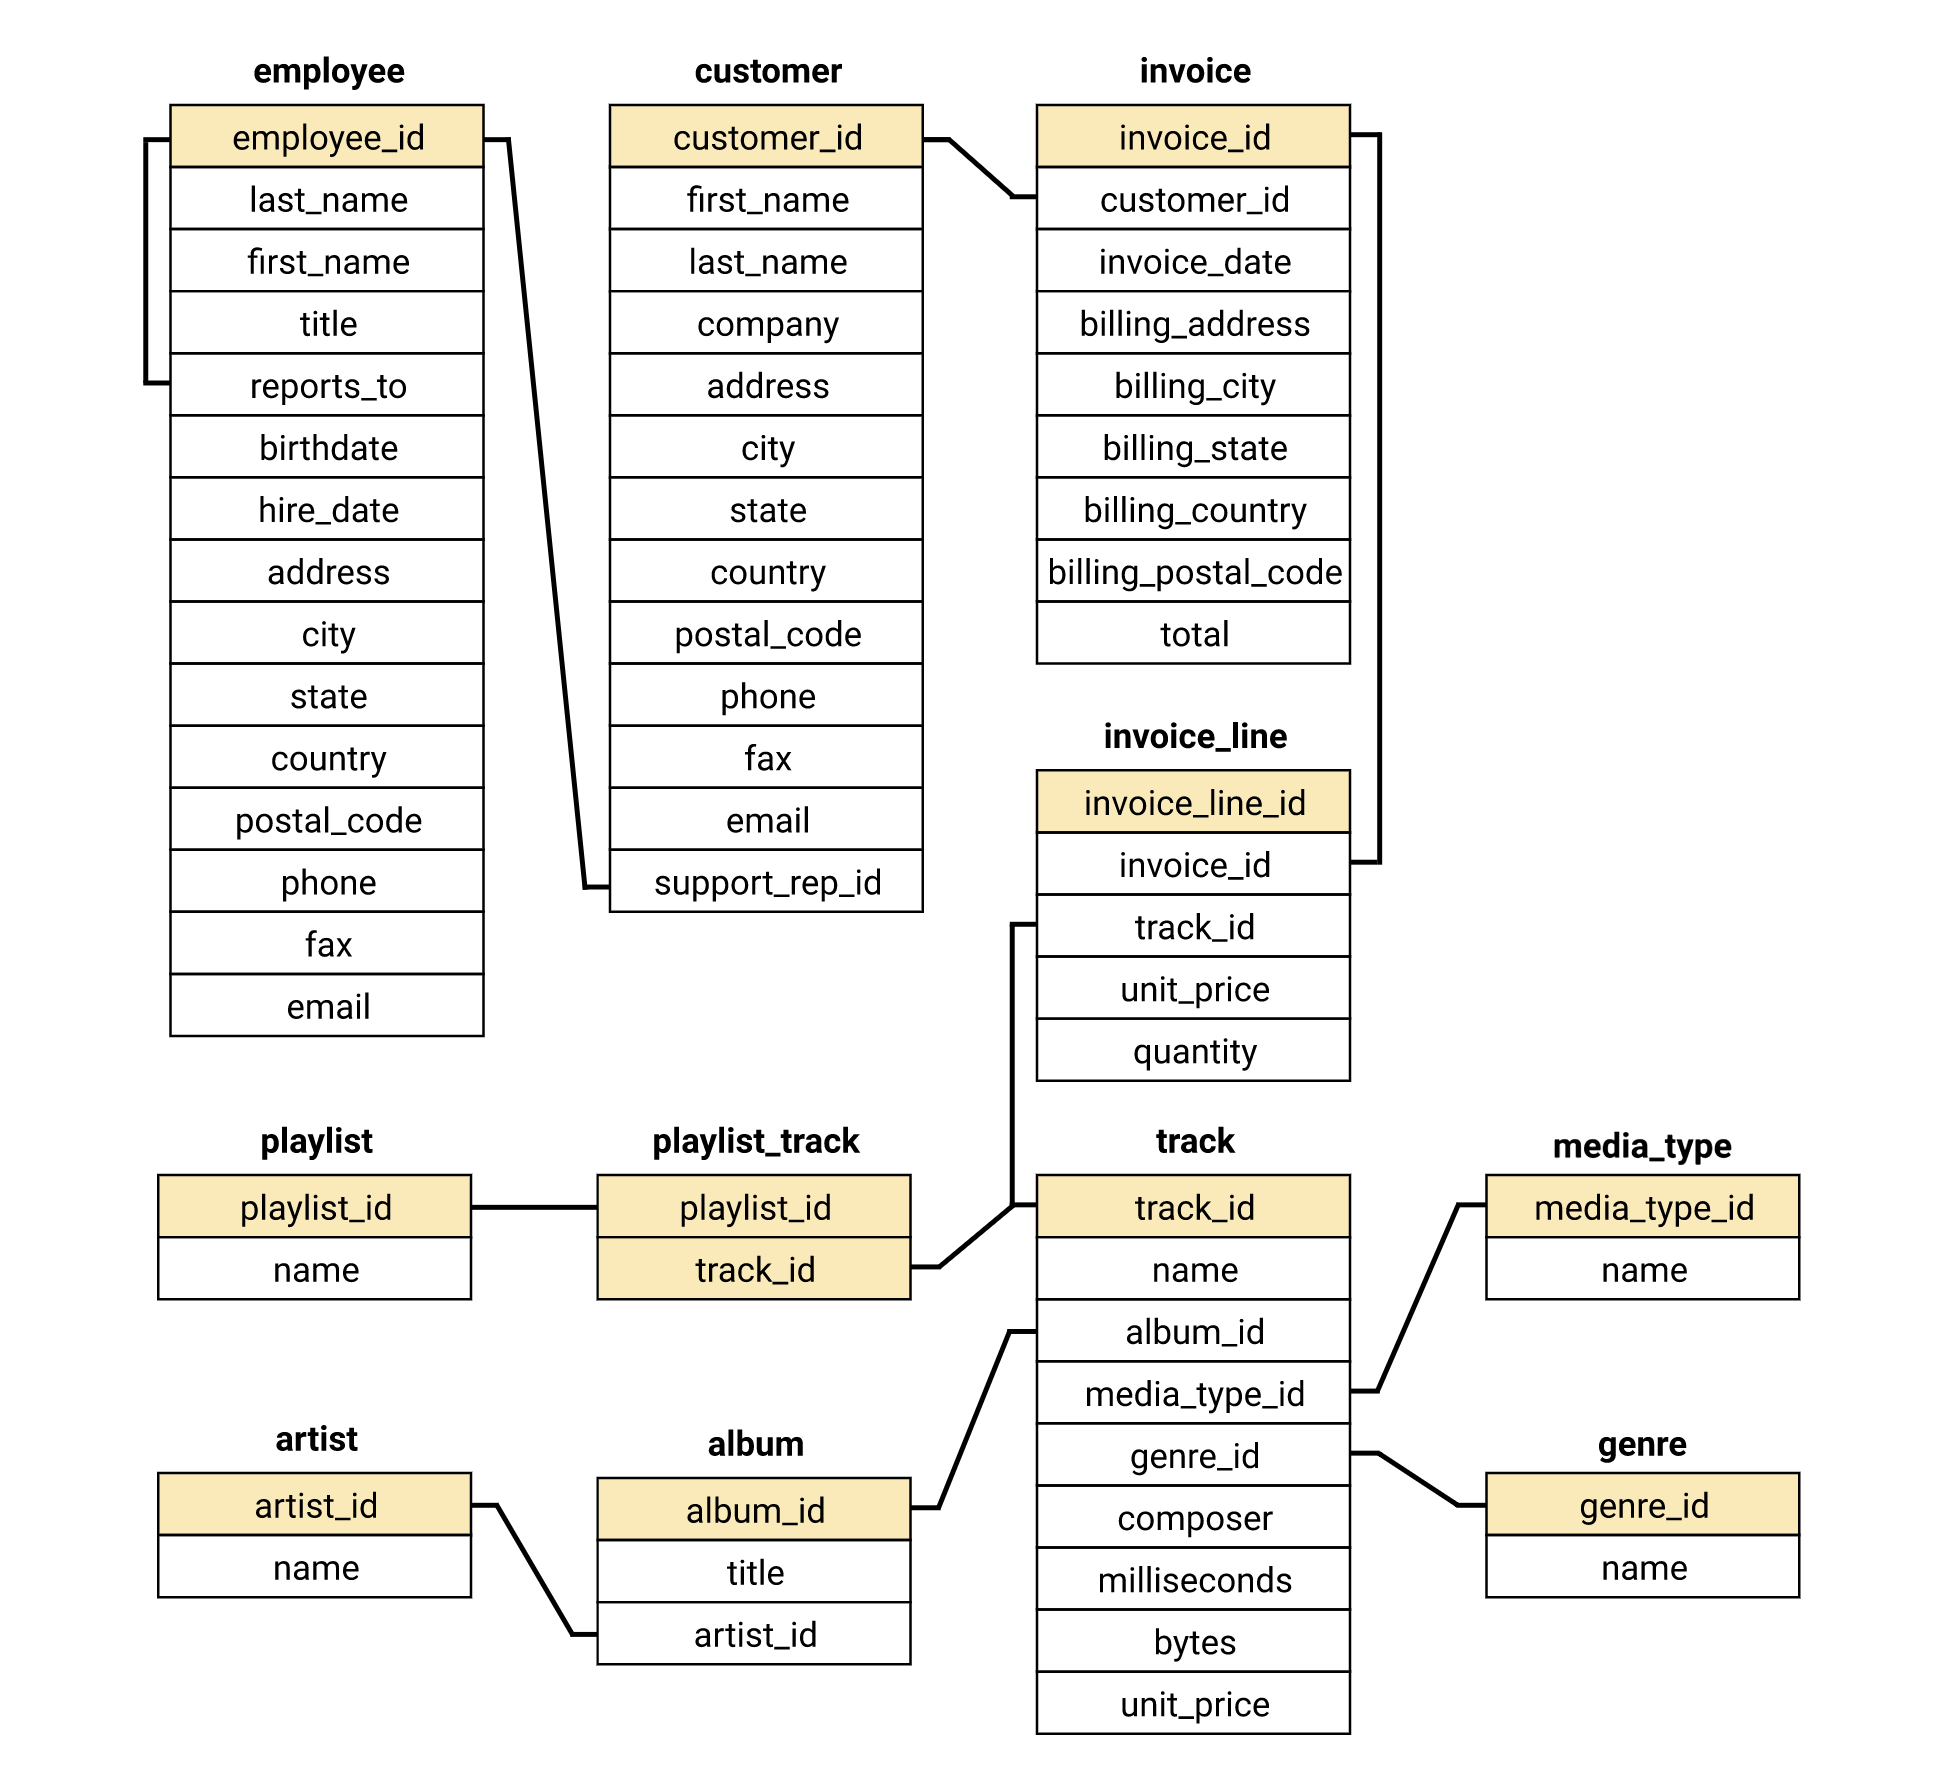

In [12]:
%%sql
SELECT *
FROM customer 
LIMIT 5;

Done.


customer_id,first_name,last_name,company,address,city,state,country,postal_code,phone,fax,email,support_rep_id
1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3
2,Leonie,Köhler,None,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,+49 0711 2842222,None,leonekohler@surfeu.de,5
3,François,Tremblay,None,1498 rue Bélanger,Montréal,QC,Canada,H2G 1A7,+1 (514) 721-4711,None,ftremblay@gmail.com,3
4,Bjørn,Hansen,None,Ullevålsveien 14,Oslo,None,Norway,0171,+47 22 44 22 22,None,bjorn.hansen@yahoo.no,4
5,František,Wichterlová,JetBrains s.r.o.,Klanova 9/506,Prague,None,Czech Republic,14700,+420 2 4172 5555,+420 2 4172 5555,frantisekw@jetbrains.com,4


In [13]:
%%sql
SELECT *
FROM genre 
LIMIT 5;

Done.


genre_id,name
1,Rock
2,Jazz
3,Metal
4,Alternative & Punk
5,Rock And Roll


In [14]:
%%sql
SELECT *
FROM track 
LIMIT 5;

Done.


track_id,name,album_id,media_type_id,genre_id,composer,milliseconds,bytes,unit_price
1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",343719,11170334,0.99
2,Balls to the Wall,2,2,1,None,342562,5510424,0.99
3,Fast As a Shark,3,2,1,"F. Baltes, S. Kaufman, U. Dirkscneider & W. Hoffman",230619,3990994,0.99
4,Restless and Wild,3,2,1,"F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. Dirkscneider & W. Hoffman",252051,4331779,0.99
5,Princess of the Dawn,3,2,1,Deaffy & R.A. Smith-Diesel,375418,6290521,0.99


In [15]:
%%sql
SELECT *
FROM invoice 
LIMIT 5;

Done.


invoice_id,customer_id,invoice_date,billing_address,billing_city,billing_state,billing_country,billing_postal_code,total
1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84
2,30,2017-01-03 00:00:00,230 Elgin Street,Ottawa,ON,Canada,K2P 1L7,9.9
3,40,2017-01-05 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,1.98
4,18,2017-01-06 00:00:00,627 Broadway,New York,NY,USA,10012-2612,7.92
5,27,2017-01-07 00:00:00,1033 N Park Ave,Tucson,AZ,USA,85719,16.83


In [16]:
%%sql
SELECT *
FROM invoice_line 
LIMIT 5;

Done.


invoice_line_id,invoice_id,track_id,unit_price,quantity
1,1,1158,0.99,1
2,1,1159,0.99,1
3,1,1160,0.99,1
4,1,1161,0.99,1
5,1,1162,0.99,1


# Scenario 1: 
#### A deal has been signed with a new record label that specializes in artists from the USA. You have been asked to select 3 albums (out of 4) to add to the store, that will sell best in USA. All 4 albums are by artists that don't have any tracks in the store right now. Below is a list of the artists and the genres there albums belong to. 

#### Artist Name/Genre:
- Regal/Hip-Hop
- Red Tone/Punk
- Meteor and the Girls/Pop
- Slim Jim Bites/Blues 


#### Our goal is to generate a table that contains the total number of tracks sold within each genre to find out what the most popular genres are so that we can decide on which albums to select. 

#### After inspecting the tables we realize that we will have to join multiple tables together to create a table that has the transaction history of all customers belonging to the USA, where each row represents a track that was purchased. The tables of interest are the *invoice*, *invoice_line*, *customer*, *genre*, and *tracks table*. Each row in the invoice table represents an invoice, and has information about the customer the invoice belongs to as well as where the invoice was billed. Each row in the invoice_line table represents a track that's associated with a given invoice (so multiple rows can correspond to the same invoice). Each row in the customer table represents a customer. The genre table contains the name associated with each genre and the tracks table has the name, genre id, album id, composer name, length, and price of each track the store carries. 


#### We need to create a table that is at the invoice line level so that we can easily count the number of tracks sold within each genre (a person can purchase multiple tracks and they would all belong to the same invoice).   
#### We first join the invoice_line table with the invoice table so that we have the customer_id associated with each invoice_line, and then we join the customer table to the previous join so that we can filter out the customers that live in the US. 
#### We create the joins described above in a WITH clause(also known as CTE or Common Table Expression). A WITH clause allows us to create a temporary dataset whose ouput can then be used by the query associated with the WITH clause. 
#### A WITH clause can help improve the readability of subqueries (query nested within another query). Subqueries can be written in any part of a query (SELECT, FROM, GROUP BY, WHERE) and have to be read inside out.
#### In the example below a temporary table called usa_tracks_sold (UTS) is created. This table is then used by the query that follows to group by genre, join the track table and genre table, count the number of tracks sold by genre, and calculate the percentage of tracks sold by genre. The track table contains the genre_id and the genre table connects the genre id to the genre name. 

In [18]:
%%sql

WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold 
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY g.name
ORDER BY percentage_sold desc

Done.


genre,tracks_sold,percentage_sold
Rock,561,0.5337773549000951
Alternative & Punk,130,0.12369172216936251
Metal,124,0.11798287345385347
R&B/Soul,53,0.05042816365366318
Blues,36,0.03425309229305423
Alternative,35,0.03330161750713606
Latin,22,0.02093244529019981
Pop,22,0.02093244529019981
Hip Hop/Rap,20,0.019029495718363463
Jazz,14,0.013320647002854425


#### Based on the above results, we decide to add Regal (Hip-Hop), Red Tone (Punk), and Slim Jim Bites (Blues)

# Scenario 2: 
#### Each customer gets assigned to a sales support agent when they make their first purchase. You are assigned to evaluate the performance of each sales support agent. Performance is evaluated by calculating the total value of sales by a support agent.

#### Lets look into what tables we will need to query for this task:
#### The invoice table contains the total amount of each invoice, as well as the customer the invoice is connected to. However, there is no information regarding which sales support agent was responsible for the invoice. The customer table, however, has the agents id connected to each customer. We can do an inner join on the customer id, to connect an invoice to a sales rep agent. We can then make our table more informative by joining the employee table, connecting the agents id to the agents name.

#### There are multiple ways to write the query. You can create a CTE, as shown in Method # 1,  at the sales support agent level, by joining the customer and invoice tables and then grouping by the support_rep_id. You can then access this CTE in the main query, joining the CTE to the employee table to get the name of the employee associated with each value total sale. An alternative method is to join all 3 tables at once in a single query, group by the sales rep id, and sum the total sales column from the invoice table.

#### Method 1: 

In [24]:
%%sql
WITH customer_support_sales AS 
    (
     SELECT c.support_rep_id employee_id, 
            sum(i.total) total_sales
     FROM customer c
     INNER JOIN invoice i on c.customer_id=i.customer_id
     GROUP BY 1 
    )      

SELECT
    e.first_name || " " || e.last_name Employee,  
    e.hire_date,
    css. total_sales
FROM customer_support_sales css
INNER JOIN employee e ON e.employee_id = css.employee_id;

Done.


Employee,hire_date,total_sales
Jane Peacock,2017-04-01 00:00:00,1731.510000000004
Margaret Park,2017-05-03 00:00:00,1584.0000000000032
Steve Johnson,2017-10-17 00:00:00,1393.9200000000028


#### Note: 
- the 1 in the WITH statement refers to c.support_rep_id
- || " " || is a concatenate operator to connect employees first and last name.

#### Method 2:

In [25]:
%%sql    
SELECT e.first_name || " " || e.last_name Employee,
       e.hire_date, 
       sum(i.total) total_sales
FROM customer c
INNER JOIN invoice i on c.customer_id=i.customer_id
INNER JOIN employee e ON e.employee_id = c.support_rep_id
GROUP BY c.support_rep_id;

Done.


Employee,hire_date,total_sales
Jane Peacock,2017-04-01 00:00:00,1731.510000000004
Margaret Park,2017-05-03 00:00:00,1584.0000000000032
Steve Johnson,2017-10-17 00:00:00,1393.9200000000028


## Scenario 3:

#### You have been asked to analyze the sales data for customers from each country.You are to calculate:
-  total number of customers 
-  total value of sales 
-  average value of sales per customer
-  average order value, for each country. 

#### You have been instructed to use the country value in the customers table and ignore the country from the billing address in the invoice table. There are some countries that only have one customer. In your output, these countries are to be labeled as "OTHER"


#### Let's take a look at the tables we will need to query for this task:
- We know we will need to use the *customers table*, since that has the country value for each customer.

- In order to calculate the total value of sales, we will again need the invoice_line and invoice table. The invoice_line table doesn't inform us what customer the purchase belongs to. The invoice table, however, does have this information, and so that is why we have to join them. 

- The customer id from the invoice table helps us connect to to the customer table, which informs us on the country the customer belongs to. 

#### Once we know what tables we are using, we need to address how to label the countries that only have 1 customer labeled as "OTHER". There are two approaches: 

- Create a correlated subquery. 
- Create a VIEW of a table with a key to what each country should be labeled as and then join this key to the table needed to make the calculations.

#### A correlated subquery is one that is dependent on the outer query and can't execute alone. It takes longer to run a correlated subquery than a non-correlated subquery, because in a correlated subquery, the inner query is executed for every row in the outer query. In the query below, the correlated subquery is written within a case statement. A case statment acts like a series of if/then options for a new column. In this case, it is to set all countries that contain only 1 customer with the value of "OTHER". The value is being assigned to the country column. The correlated subquery following the WHEN, is going through each country value in the outer query (c.country) and checking if it matches to the country value from the customers table in the subquery. The total number of matches is then counted (count(*)). If the count is 1, then the country only has one customer and the value is set to "Other", else it is set to the country name. 

#### An alternative method to the one described above involves creating a VIEW. A view is a virtual table that can be accessed outside of the query (unlike a CTE). We first create a VIEW of a table that contains the key as to how each country will be labeld ("Other" or keep it's name). We do this by creating a CTE called country_count, by grouping by country, and counting the number of unique customers belonging to each country. The query outputs two columns (customer_count and country name). This table is then used in a query to create an additional column, where the value is 'OTHER' if the customer_count is 1, else the countries name is kept. By using CREATE VIEW AS, the output is a permanent table that can then be used in subsequent queries. A second VIEW is created to construct a table will be needed to perform the calculations mentioned above. The customer, invoice, and invoice_line table are joined. The customer_id, country, and all columns in the invoice line table are selected. We then join together the output of the two views we created, to add the updated labels for each country to the table that has the information needed to do the calculations. The join is done within a WITH statement. The temporary table is then used to produce the final result. In order to display the "Other" country label at the very end of the final ouptut you can create a case statement in which you create a column called sort. Within this column you assign 1 to all rows in which the country_relabeled column has a "Other", and a 0 to all the rows in which the country column value is the country name. Then you can order by the sort column, such that "Other" category is on the bottom. 


#### Method 1: Using a correlated subquery

In [26]:
%%sql
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )
    
SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC


Done.


country,customers,total_sales,customer_lifetime_value,average_order,sort
USA,13,1040.490000000008,80.03769230769292,7.942671755725252,0
Canada,8,535.5900000000034,66.94875000000043,7.047236842105309,0
Brazil,5,427.68000000000245,85.53600000000048,7.011147540983647,0
France,5,389.0700000000021,77.81400000000042,7.781400000000042,0
Germany,4,334.6200000000016,83.6550000000004,8.161463414634186,0
Czech Republic,2,273.24000000000103,136.62000000000052,9.108000000000034,0
United Kingdom,3,245.52000000000078,81.84000000000026,8.768571428571457,0
Portugal,2,185.13000000000022,92.56500000000011,6.3837931034482835,0
India,2,183.1500000000002,91.5750000000001,8.72142857142858,0
Other,15,1094.9400000000085,72.99600000000056,7.448571428571486,1


#### Method 2: Creating Views 

In [28]:
%%sql 
CREATE VIEW country_or_other_dict AS 
    
WITH country_count AS 
    (
     SELECT count (distinct c.customer_id) customer_count, c.country
     FROM customer c
     GROUP BY c.country       
    )
   
 SELECT     
    co.*, 
    CASE 
        WHEN co.customer_count =1 THEN 'Other'
        ELSE co.country
        END AS country_relabeled
FROM country_count co
    

Done.


[]

#### Note:
- When writing a CTE with a view, always create a VIEW first 
- A CTE is created to count the number of customers per country
- A dictionary is then created, assigning "Other" name to countries with only 1 customer  
- co.* selects all rows in country_count table

#### Below is the ouput of above VIEW 

In [30]:
%%sql
SELECT * FROM country_or_other_dict; 

Done.


customer_count,country,country_relabeled
1,Argentina,Other
1,Australia,Other
1,Austria,Other
1,Belgium,Other
5,Brazil,Brazil
8,Canada,Canada
1,Chile,Other
2,Czech Republic,Czech Republic
1,Denmark,Other
1,Finland,Other


#### Create table with information needed to do calculations

In [ ]:
%%sql
CREATE VIEW c_il_i_updated AS 
    SELECT
       c.country,
        c.customer_id,
        il.*
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id;

#### Below is the ouput of above view. 

In [5]:
%%sql
SELECT * FROM c_il_i_updated;
limit 5; 

Done.
(sqlite3.OperationalError) near "limit": syntax error
[SQL: limit 5;]
(Background on this error at: http://sqlalche.me/e/13/e3q8)


In [36]:
%%sql

WITH final_table AS 
(SELECT cili_u.*, co.country_relabeled 
 FROM c_il_i_updated cili_u
 INNER JOIN country_or_other_dict co ON co.country=cili_u.country)

SELECT
        country_relabeled,
        count(distinct customer_id) customers, 
        SUM(unit_price) total_sales, 
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country_relabeled = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM final_table
    GROUP BY country_relabeled
    ORDER BY sort ASC, total_sales DESC;


Done.


country_relabeled,customers,total_sales,customer_lifetime_value,average_order,sort
USA,13,1040.490000000008,80.03769230769292,7.942671755725252,0
Canada,8,535.5900000000034,66.94875000000043,7.047236842105309,0
Brazil,5,427.68000000000245,85.53600000000048,7.011147540983647,0
France,5,389.0700000000021,77.81400000000042,7.781400000000042,0
Germany,4,334.6200000000016,83.6550000000004,8.161463414634186,0
Czech Republic,2,273.24000000000103,136.62000000000052,9.108000000000034,0
United Kingdom,3,245.52000000000078,81.84000000000026,8.768571428571457,0
Portugal,2,185.13000000000022,92.56500000000011,6.3837931034482835,0
India,2,183.1500000000002,91.5750000000001,8.72142857142858,0
Other,15,1094.9400000000085,72.99600000000056,7.448571428571486,1
